Hi guys, here is a python notebook where we can do some analysis of our data.

In [1]:
# imports the libraries needed for the project
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# time converter to datetime object for the OMNI data
tconvert = lambda x: dt.datetime.strptime(str(x), '%Y-%m-%dT%H:%M:%S.%fZ')
# reads the OMNI data into arrays
data = np.genfromtxt('OMNI20032024.csv', names=True, delimiter=',', skip_header=94, encoding='utf-8',converters={0:tconvert}, dtype=None)

time = data['TIME_AT_CENTER_OF_HOUR_yyyymmddThhmmsssssZ']
swavgB = np.array(data['1AU_IP_MAG_AVG_B_nT'], dtype = float)
swvelocity = np.array(data['1AU_IP_PLASMA_SPEED_Kms'], dtype = float)
swpressure = np.array(data['1AU_IP_FLOW_PRESSURE_nPa'], dtype = float)
swtemp = np.array(data ['1AU_IP_PLASMA_TEMP_Deg_K'], dtype = float)
swdensity = np.array(data['1AU_IP_N_ION_Per_cc'], dtype = float)
dst = np.array(data['1H_DST_nT'], dtype = float)

In [2]:
# values that need to be filtered due to null data points
arrays = [swavgB, swdensity, swvelocity, swpressure, swtemp]
# maxs of the legitimate from OMNI
filters = [80, 100, 1200, 60, 1*10**7]
# filters out non data points to be null
for array, threshold in zip(arrays, filters):
    for index, value in enumerate(array):
        if value >= threshold:
            array[index] = np.nan

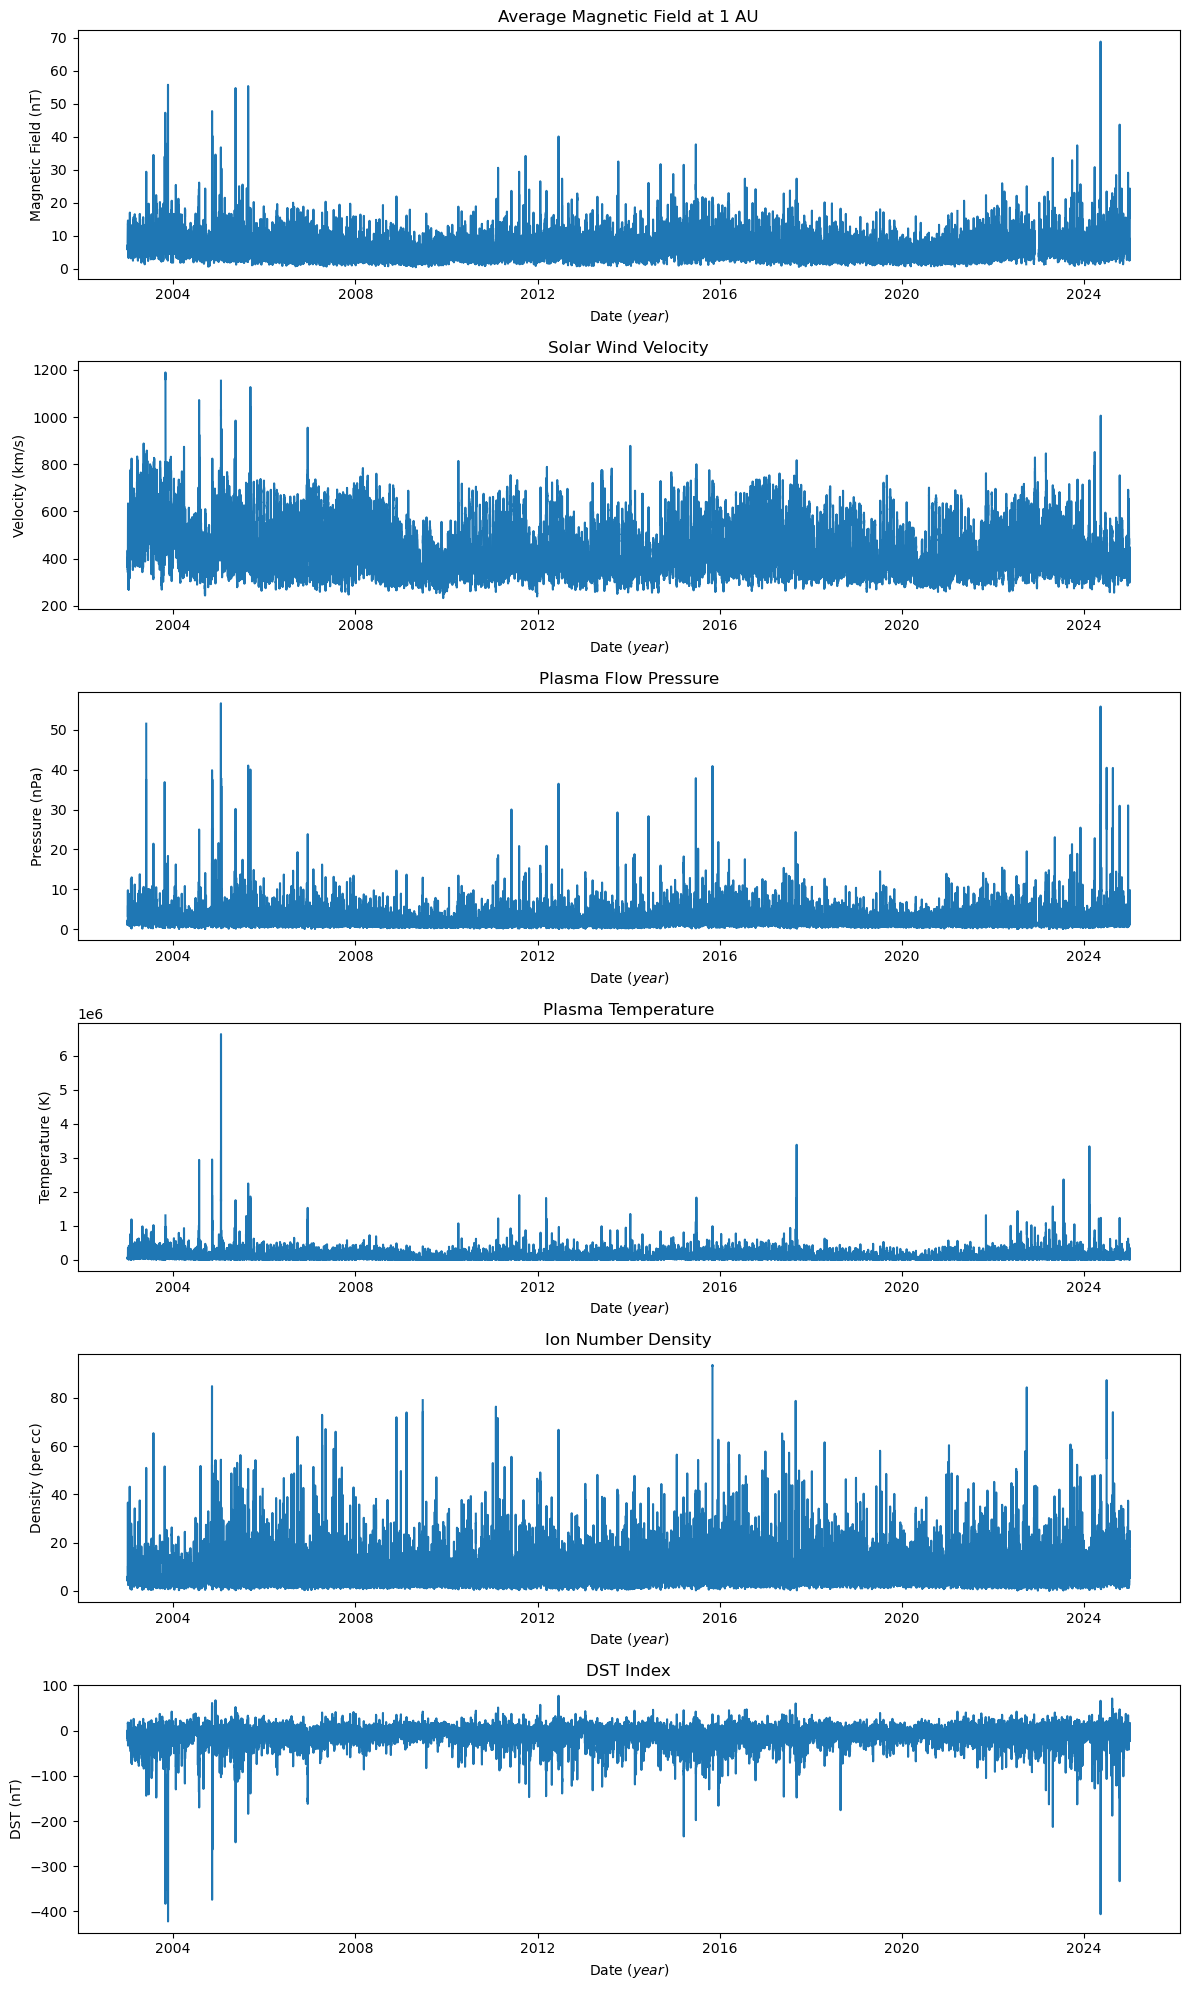

In [3]:
# correlates data to labels
data = {'Average Magnetic Field at 1 AU|Magnetic Field (nT)': (time,swavgB),
        'Solar Wind Velocity|Velocity (km/s)': (time,swvelocity),
        'Plasma Flow Pressure|Pressure (nPa)': (time,swpressure),
        'Plasma Temperature|Temperature (K)': (time,swtemp),
        'Ion Number Density|Density (per cc)': (time,swdensity),
        'DST Index|DST (nT)': (time,dst)}
fig, axes = plt.subplots(6,1, figsize = (12,20))
# for loop to add data to each plot
for ax, (label, (x, y)) in zip(axes.flat, data.items()):
    #add data to the plot
    ax.plot(x,y)
    # adds proper titles and labels
    title, space, ytext = label.partition('|')
    ax.set_title(title)   
    ax.set_xlabel(r'Date $(year)$')
    ax.set_ylabel(ytext)
fig.tight_layout()

https://nhess.copernicus.org/preprints/nhess-2018-92/nhess-2018-92.pdf
"Thresholds for geomagnetic storms can be chosen by common values of SYM-H and Dst, as –75 nT for moderate storms; –150 nT for intense storms, and –330 nT for extreme storms."

In [20]:
storm_idxs = np.where(dst < -75)[0]
dst_storms = dst[storm_idxs]
storm_times = time[storm_idxs]
#plt.plot(storm_times, dst_storms)

In [ ]:
events = []
event = np.array([])
for i in range(len(storm_idxs)):
    if (event.size == 0):
        event = np.append(event, storm_idxs[i])
    elif(storm_idxs[i] - 1 == storm_idxs[i-1]):
        event = np.append(event, storm_idxs[i])
    elif(storm_idxs[i] - 1 != storm_idxs[i-1]):
        event
        events.append(event)
        event = np.array([])

In [75]:
storms = []
moderate = []
intense = []
extreme = []
for event in events:
    event = event.astype(int)
    min_idx = np.argmin(dst[event])
    event_min = np.min(dst[event])
    event_time = time[event[min_idx]]
    storms.append([event_time, event_min])
    if(event_min < -330):
        extreme.append([event_time, event_min])
    elif(event_min < -150):
        intense.append([event_time, event_min])
    else:
        moderate.append([event_time, event_min])

dst_events = {"storms":storms, "moderate":moderate, "intense":intense, "extreme":extreme}

In [102]:
idx_min = np.argmin(dst)
minimum = dst[idx_min]
min_time = time[idx_min]
print(min_time, minimum, dst_events['extreme'])

2003-11-20 20:30:00 -422.0 [[datetime.datetime(2003, 10, 30, 22, 30), -383.0], [datetime.datetime(2003, 11, 20, 20, 30), -422.0], [datetime.datetime(2004, 11, 8, 6, 30), -374.0], [datetime.datetime(2024, 5, 11, 2, 30), -406.0], [datetime.datetime(2024, 10, 11, 1, 30), -333.0]]
